In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss


import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:\\Users\\Owner\\AppLearner\\src')
import framework__data_set as ds

import os
import warnings

warnings.filterwarnings("ignore")

In [32]:
dataset = ds.get_data_set(
    metric="container_cpu",
    application_name="dns",
    path_to_data="C:\\Users\\Owner\\AppLearner\\data\\OperatreFirst_PrometheusData_AppLearner\\"
)

In [ ]:
x = [dataset[i].iloc[:707,:] for i in range(len(dataset)) if max(dataset[i]["time_idx"])>707]

In [ ]:
for i in range(len(x)):
    x[i]["series"] = i


In [50]:
data = pd.concat(x,ignore_index=True)
data.rename(columns = {'sample':'value'}, inplace = True)
data = data.astype(dict(series=str))
data

,value,series,time,time_idx
0,0.002174,0,2022-04-19 17:16:00,0
1,0.003037,0,2022-04-19 17:17:00,1
2,0.004147,0,2022-04-19 17:18:00,2
3,0.005510,0,2022-04-19 17:19:00,3
4,0.006653,0,2022-04-19 17:20:00,4
...,...,...,...,...
509035,0.011903,719,2022-06-13 20:43:00,702
509036,0.011830,719,2022-06-13 20:44:00,703
509037,0.012229,719,2022-06-13 20:45:00,704
509038,0.012399,719,2022-06-13 20:46:00,705


In [ ]:
# data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
# data["static"] = 2
# data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
# data

In [54]:
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized" #?
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized" #?
)

In [ ]:
[y[0] for x, y in iter(val_dataloader)]

In [56]:
training_cutoff

686

In [57]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.0824)

In [58]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(gpus=0, gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training, learning_rate=3e-2, hidden_size=30, rnn_layers=2, loss=MultivariateNormalDistributionLoss(rank=30)
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
#
# res = trainer.tuner.lr_find(
#     net,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     min_lr=1e-5,
#     max_lr=1e0,
#     early_stop_threshold=100,
# )
# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()
# net.hparams.learning_rate = res.suggestion()

In [60]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 46.1 K
3 | rnn                    | LSTM                               | 19.1 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
66.2 K    Trainable params
0         Non-trainable params
66.2 K    Total params
0.265     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 56/56 [00:18<00:00,  3.05it/s, loss=-833, v_num=2, train_loss_step=-844., val_loss=-800., train_loss_epoch=-831.] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 56/56 [00:18<00:00,  3.05it/s, loss=-833, v_num=2, train_loss_step=-844., val_loss=-800., train_loss_epoch=-831.]


In [61]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [62]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0005)

In [63]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

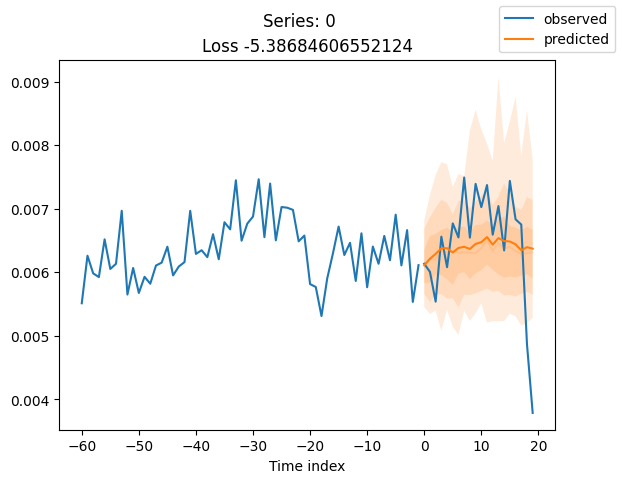

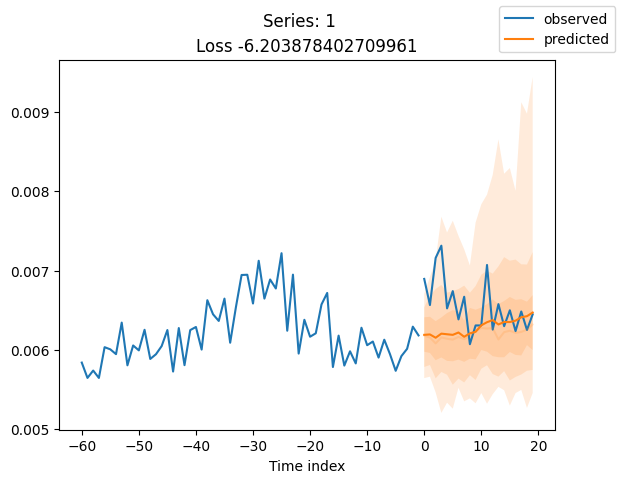

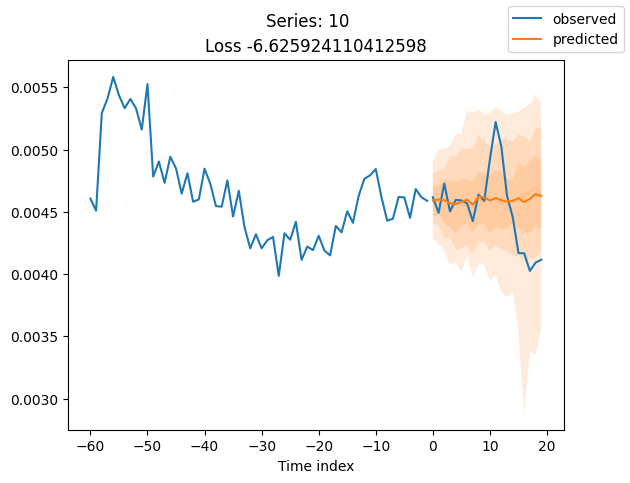

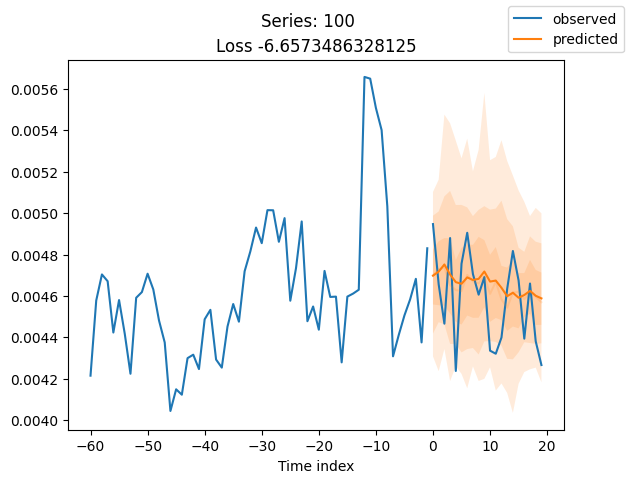

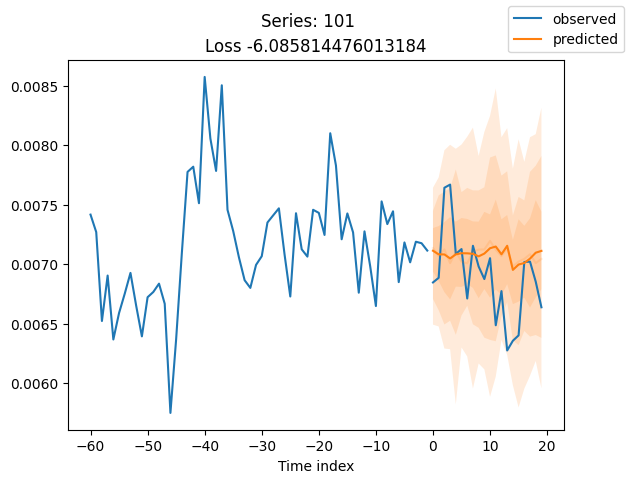

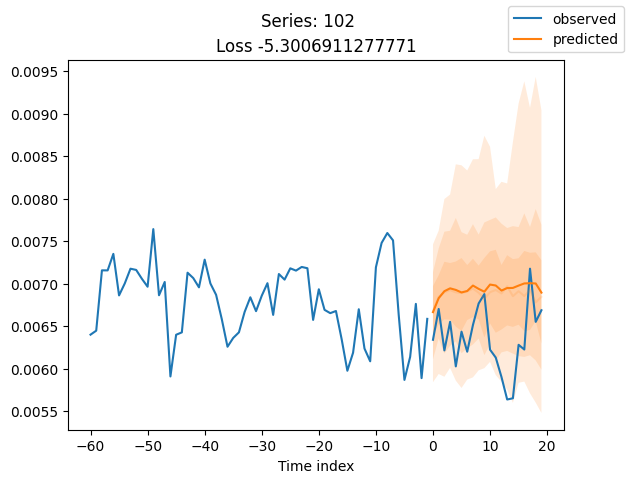

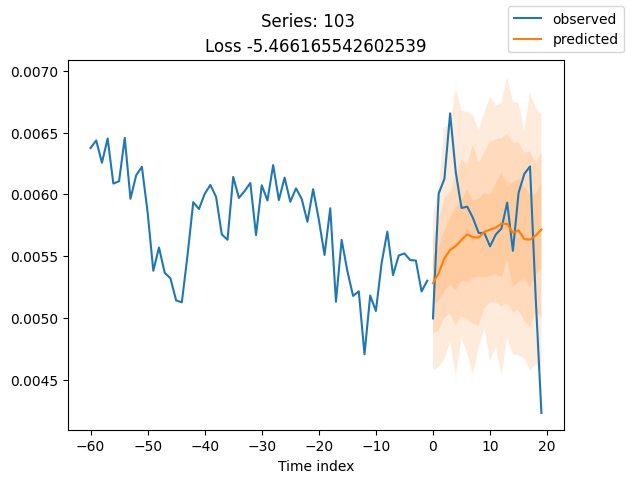

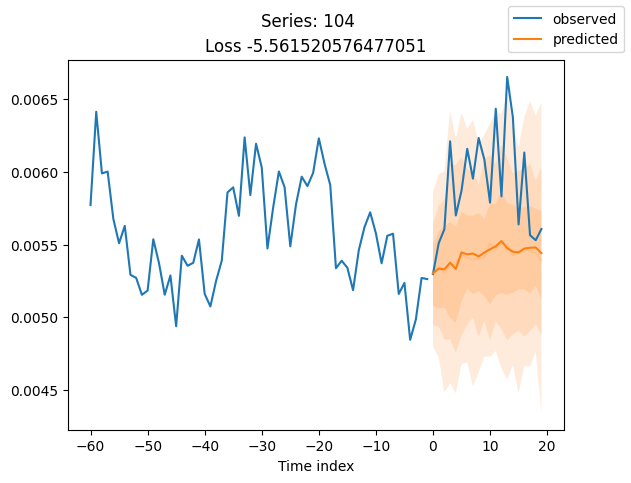

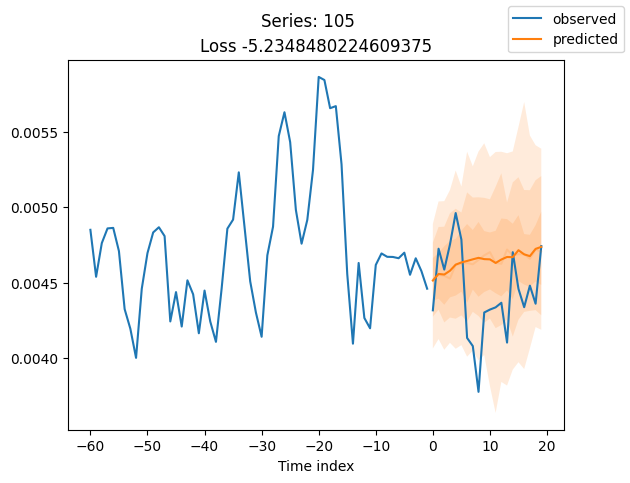

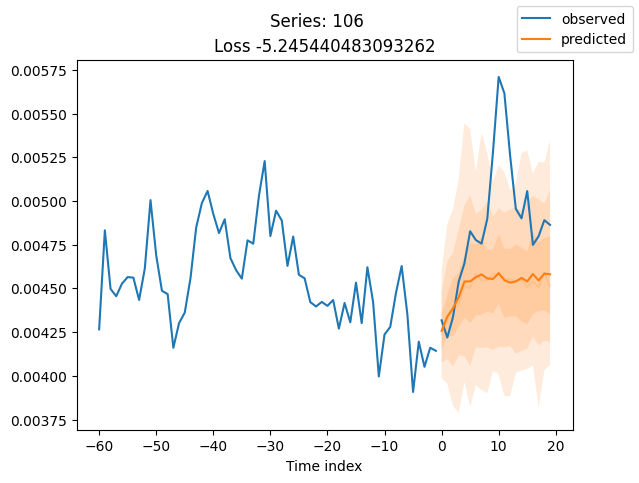

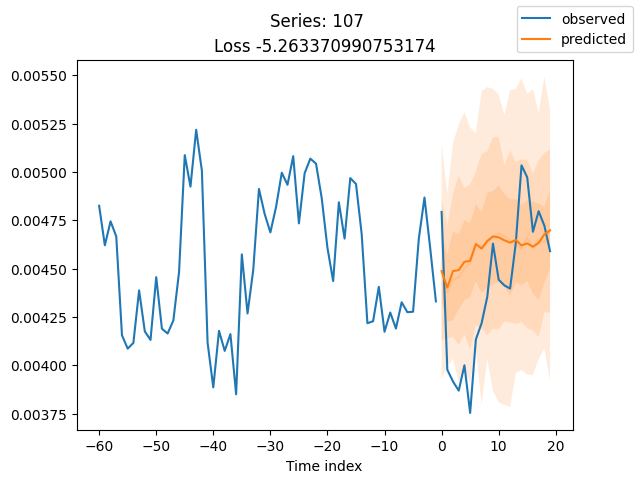

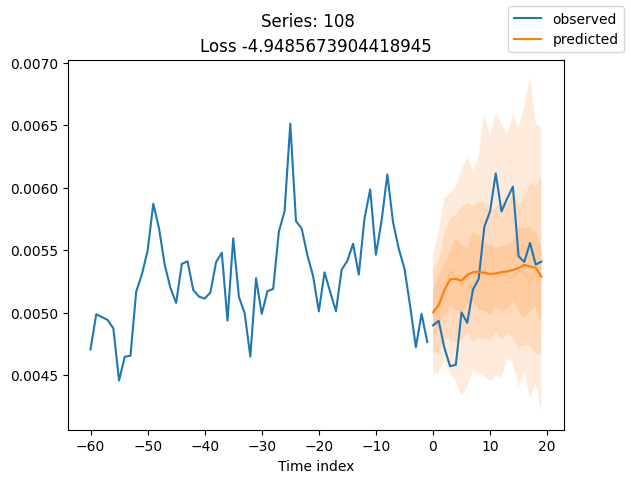

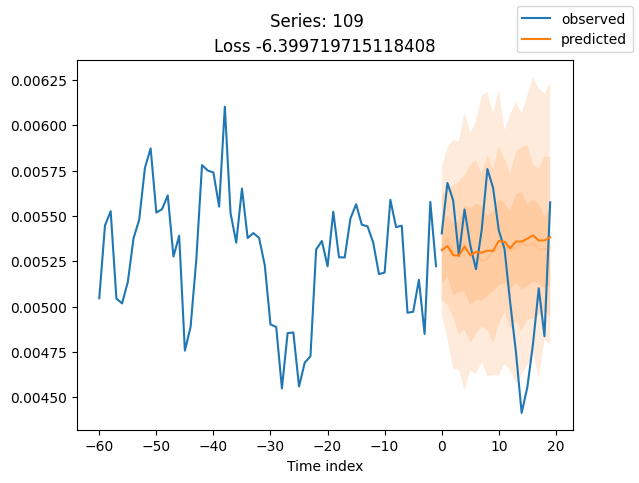

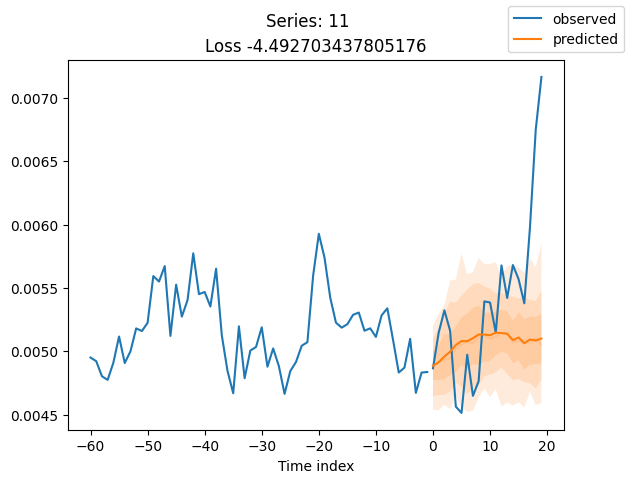

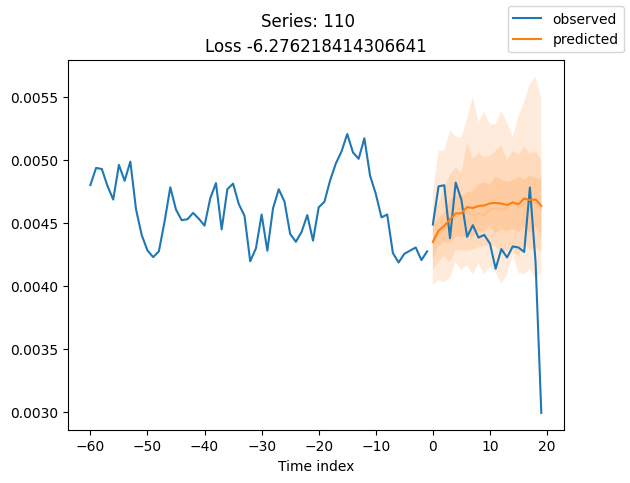

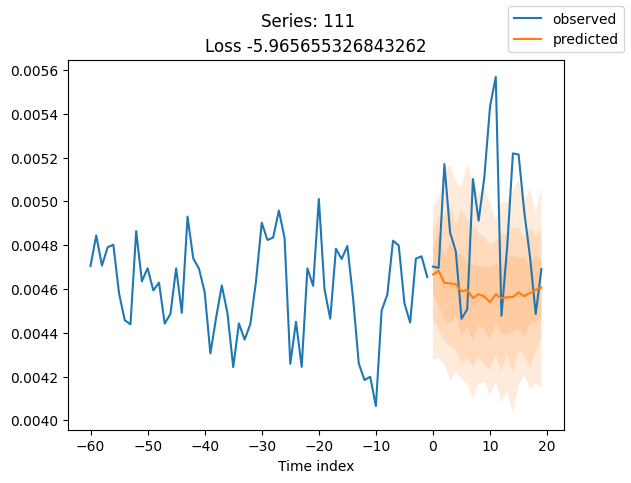

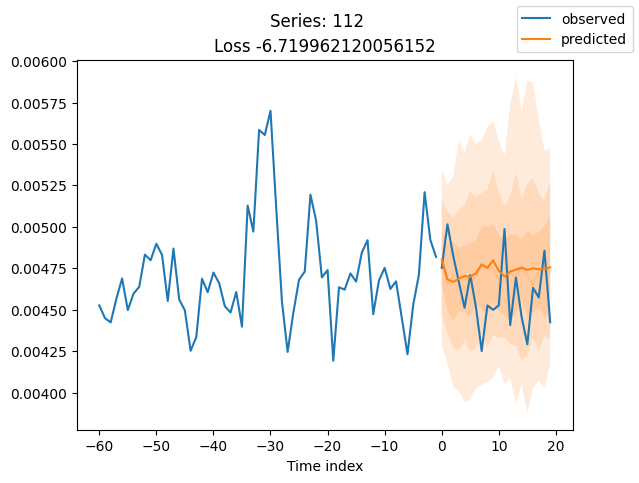

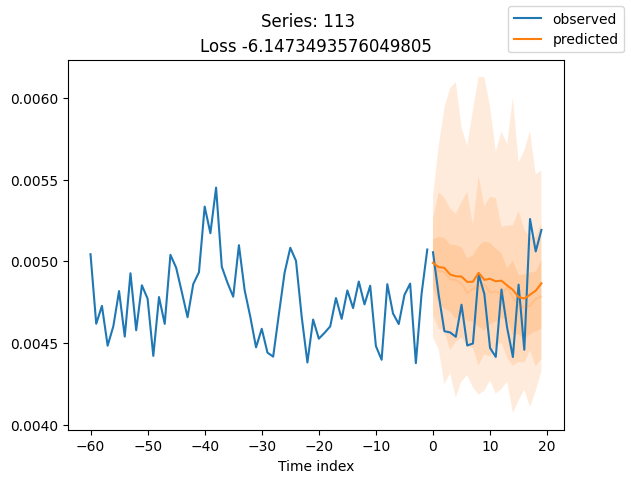

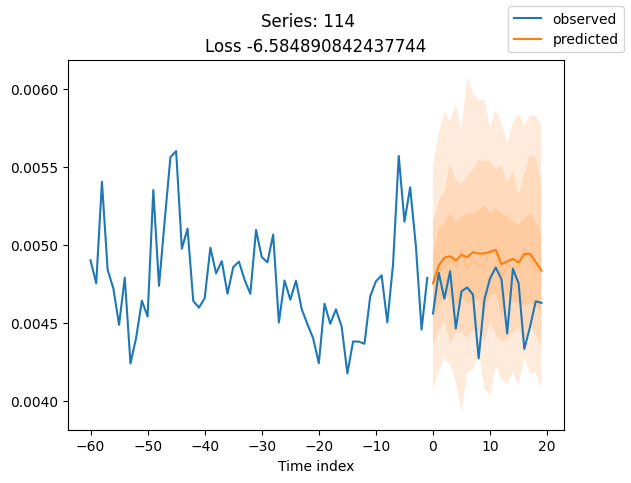

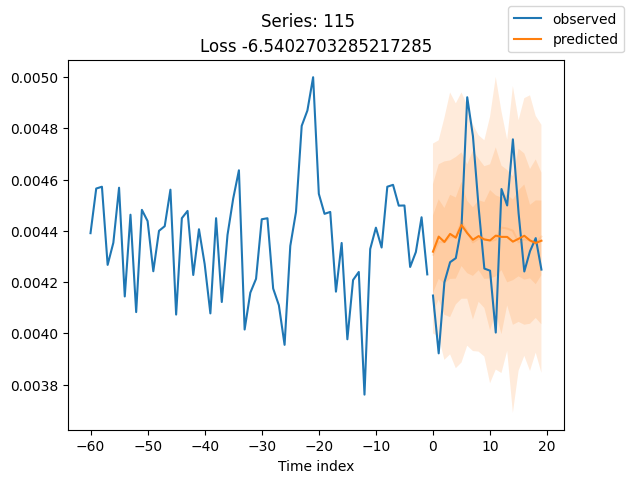

In [64]:
series = validation.x_to_index(x)["series"]
for idx in range(20):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

In [67]:
x

{'encoder_cat': tensor([[[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  1],
          [  1],
          [  1],
          ...,
          [  1],
          [  1],
          [  1]],
 
         [[  2],
          [  2],
          [  2],
          ...,
          [  2],
          [  2],
          [  2]],
 
         ...,
 
         [[717],
          [717],
          [717],
          ...,
          [717],
          [717],
          [717]],
 
         [[718],
          [718],
          [718],
          ...,
          [718],
          [718],
          [718]],
 
         [[719],
          [719],
          [719],
          ...,
          [719],
          [719],
          [719]]]),
 'encoder_cont': tensor([[[-1.7210],
          [-0.1664],
          [-0.7441],
          ...,
          [ 0.6689],
          [-1.6769],
          [-0.4751]],
 
         [[-0.9744],
          [-1.4750],
          [-1.2342],
          ...,
          [